<a href="https://colab.research.google.com/github/sumitch23/Alzheimer-Detection/blob/main/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage.color import gray2rgb


In [ ]:
pip install -U scikit-image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 28.8 MB/s eta 0:00:00
  Attempting uninstall: imageio
    Found existing installation: imageio 2.31.6
    Uninstalling imageio-2.31.6:
      Successfully uninstalled imageio-2.31.6
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Uninstalling scikit-image-0.19.3:
      Successfully uninstalled scikit-image-0.19.3


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=30,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset  = train_datagen.flow_from_directory(directory = '/content/drive/MyDrive/test',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 1025 images belonging to 4 classes.


In [ ]:
valid_dataset = valid_datagen.flow_from_directory(directory = '/content/drive/MyDrive/test',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 254 images belonging to 4 classes.


100%|██████████| 5/5 [00:00<00:00, 292.69it/s]


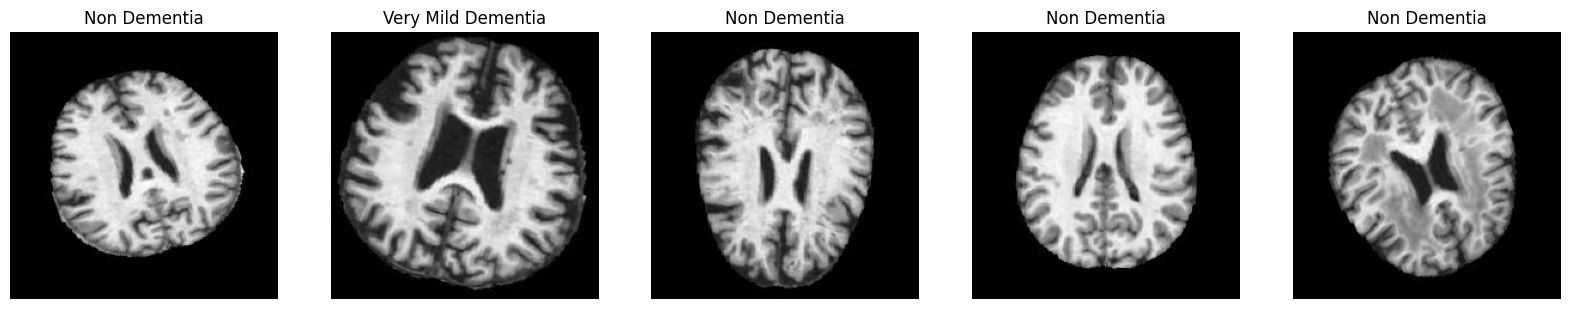

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Assuming 'train_dataset' is your data generator
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 20))

# Fetch a batch from the dataset
batch = next(iter(train_dataset))  # Use the first batch for simplicity
images, labels = batch[0], batch[1]

for i in tqdm(range(5)):
    rand_idx = np.random.randint(len(images))  # Randomly select an image in the batch
    ax[i].imshow(images[rand_idx])
    ax[i].axis('off')

    label = labels[rand_idx]
    if label[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif label[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif label[2] == 1:
        ax[i].set_title('Non Dementia')
    elif label[3] == 1:
        ax[i].set_title('Very Mild Dementia')

plt.show()


In [ ]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3),
                         include_top=False,
                         weights="imagenet")

In [ ]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [ ]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [ ]:
# Summary

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 1664)        0         
                                                                 
 flatten_1 (Flatten)         (None, 81536)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 81536)             326144    
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 2048)              166987776 
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                     

In [ ]:
# Model Compile

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

In [ ]:
# Defining Callbacks

filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_auc',
                              mode = 'max' ,
                              patience = 15,
                              verbose = 1)

checkpoint    = ModelCheckpoint(filepath,
                                monitor = 'val_auc',
                                mode='max',
                                save_best_only=True,
                                verbose = 1)


callback_list = [earlystopping, checkpoint]

In [ ]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 500,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/500
9/9 [==============================] - ETA: 0s - loss: 1.7040 - auc: 0.7047 
Epoch 1: val_auc improved from -inf to 0.69540, saving model to ./best_weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 526s 55s/step - loss: 1.7040 - auc: 0.7047 - val_loss: 10.2352 - val_auc: 0.6954
Epoch 2/500
9/9 [==============================] - ETA: 0s - loss: 1.2950 - auc: 0.8120 
Epoch 2: val_auc improved from 0.69540 to 0.78341, saving model to ./best_weights.hdf5
9/9 [==============================] - 471s 53s/step - loss: 1.2950 - auc: 0.8120 - val_loss: 3.5648 - val_auc: 0.7834
Epoch 3/500
9/9 [==============================] - ETA: 0s - loss: 1.1435 - auc: 0.8321 
Epoch 3: val_auc did not improve from 0.78341
9/9 [==============================] - 420s 52s/step - loss: 1.1435 - auc: 0.8321 - val_loss: 6.9483 - val_auc: 0.7019
Epoch 4/500
9/9 [==============================] - ETA: 0s - loss: 1.1017 - auc: 0.8402 
Epoch 4: val_auc improved from 0.78341 to 0.81453, saving model to ./best_weights.hdf5
9/9 [==============================] - 486s 60s/step - loss: 1.1017 - auc: 0.8402 - val_loss: 3.2965 - val_auc: 0.8145
Epoch 5/500
9/9 [===================

KeyboardInterrupt: 

In [ ]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

NameError: name 'model_history' is not defined

In [ ]:
# Test Data

test_dataset  = test_datagen.flow_from_directory(directory = '/content/drive/MyDrive/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [ ]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 343s 34s/step - loss: 0.6937 - auc: 0.9338


[0.6937028765678406, 0.9338260293006897]

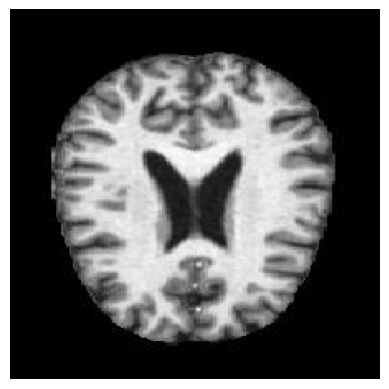

1/1 [==============================] - 5s 5s/step


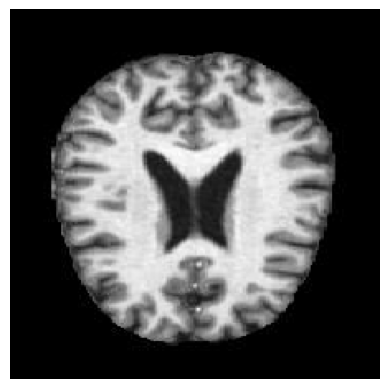

99.98% chances are there that the image is NonDemented


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

# Assuming 'model' is your trained Sequential model

# Load and preprocess the image
img_path = '26 (100).jpg'  # Update with your image path
img = load_img(img_path, target_size=(224, 224))  # Ensure target size matches model input
img_array = img_to_array(img)

# Display the image in original format (before normalization)
plt.imshow(img_array.astype('uint8'))
plt.axis('off')
plt.show()

# Normalize pixel values
img_array = img_array / 255.0

# Expand dimensions to match the model's expected input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict probabilities
probabilities = model.predict(img_array)

# Get predicted class index
predicted_class_index = np.argmax(probabilities)

# Get class label using class indices dictionary
class_indices = test_dataset.class_indices
idc = {v: k for k, v in class_indices.items()}
predicted_class_label = idc[predicted_class_index]

# Get probability score
probability_score = round(probabilities[0][predicted_class_index] * 100, 2)

# Display the normalized image used for prediction
plt.imshow(np.squeeze(img_array))
plt.axis('off')
plt.show()

print(f"{probability_score}% chances are there that the image is {predicted_class_label}")


1/1 [==============================] - 0s 293ms/step


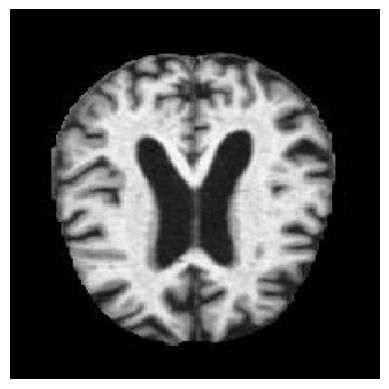

59.02% chances are there that the image is MildDemented


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming 'model' is your trained Sequential model

# Load and preprocess the image
img_path = '26 (19).jpg'
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = img_array / 255.0  # Normalize pixel values

# Expand dimensions to match the model's expected input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict probabilities
probabilities = model.predict(img_array)

# Get predicted class index
predicted_class_index = np.argmax(probabilities)

# Get class label using class indices dictionary
class_indices = test_dataset.class_indices
idc = {v: k for k, v in class_indices.items()}
predicted_class_label = idc[predicted_class_index]

# Get probability score
probability_score = round(probabilities[0][predicted_class_index] * 100, 2)

# Display results
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"{probability_score}% chances are there that the image is {predicted_class_label}")


1/1 [==============================] - 0s 333ms/step


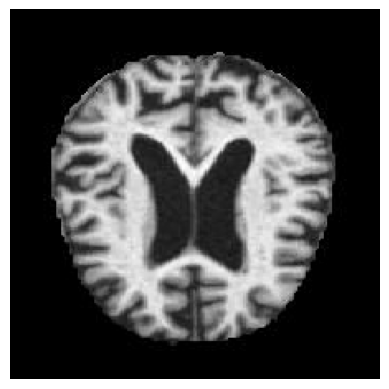

48.48% chances are there that the image is ModerateDemented


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming 'model' is your trained Sequential model

# Load and preprocess the image
img_path = '27 (2).jpg'
img = load_img(img_path, target_size=(224, 224))  # Ensure target size matches model input
img_array = img_to_array(img)

# Normalize pixel values (using the same method as during model training)
img_array = img_array / 255.0

# Expand dimensions to match the model's expected input shape
img_array = np.expand_dims(img_array, axis=0)

# Predict probabilities
probabilities = model.predict(img_array)

# Get predicted class index
predicted_class_index = np.argmax(probabilities)

# Get class label using class indices dictionary
class_indices = test_dataset.class_indices
idc = {v: k for k, v in class_indices.items()}
predicted_class_label = idc[predicted_class_index]

# Get probability score
probability_score = round(probabilities[0][predicted_class_index] * 100, 2)

# Display results
plt.imshow(img)
plt.axis('off')
plt.show()

print(f"{probability_score}% chances are there that the image is {predicted_class_label}")


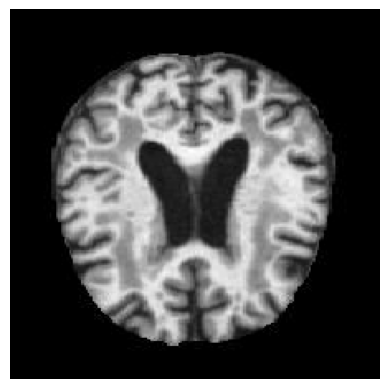

1/1 [==============================] - 1s 845ms/step
78.52% chances are there that the image is NonDemented


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Assuming 'model' is your trained Sequential model

# Mapping of class indices to labels
class_indices = test_dataset.class_indices
idc = {v: k for k, v in class_indices.items()}  # Correct the dictionary mapping

# Load and preprocess the image
img_path = '26 (55).jpg'  # Update with your image path
img = load_img(img_path, target_size=(224, 224))  # Ensure target size matches model input
img = img_to_array(img)
img = img / 255.0  # Normalize pixel values

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Expand dimensions to match the model's expected input shape
img = np.expand_dims(img, axis=0)

# Predict probabilities
probabilities = model.predict(img)

# Get predicted class index
predicted_class_index = np.argmax(probabilities)

# Get probability score
probability_score = round(probabilities[0][predicted_class_index] * 100, 2)

# Print the results
predicted_class_label = idc[predicted_class_index]
print(f"{probability_score}% chances are there that the image is {predicted_class_label}")
